<a href="https://colab.research.google.com/github/mailazorzan/credit_card_segmentation/blob/main/credit_card.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Credit Card Segmentation

O objetivo é o desenvolvimento de uma segmentação de clientes para definir uma estratégia de marketing. O conjunto de dados de amostra resume o comportamento de uso de cerca de 9.000 titulares de cartões de crédito ativos durante os últimos 6 meses. O arquivo é por cliente e tem 18 variáveis ​​comportamentais:

  *    CUSTID: identificação do titular do cartão de crédito (categórico);
  *    BALANCE: saldo restante na conta;
  *    BALANCE_FREQUENCY: a frequência com que o saldo é atualizado - pontuação entre 0 e 1 - 1 = atualizado com frequência, 0 = não atualizado com frequência;
  *    PURCHASES: quantidade de compras feitas na conta;
  *    ONEOFF_PURCHASES: valor máximo da compra feita de uma vez;
  *    INSTALLMENTS_PURCHASES: valor da compra feita a prazo;
  *    CASH_ADVANCE: adiantamento em dinheiro dado pelo usuário;
  *    PURCHASES_FREQUENCY: a frequência com que as compras estão sendo feitas - pontuação entre 0 e 1 - 1 = compra frequente, 0 = compra não frequente;
  *    ONEOFF_PURCHASES_FREQUENCY: a frequência com que as compras acontecem de uma só vez - 1 = compra frequente, 0 = compra não frequente;
  *    PURCHASES_INSTALLMENTS_FREQUENCY: com que frequência as compras parceladas estão sendo feitas - 1 = freqüentemente feito, 0 = não freqüentemente feito;
  *    CASH_ADVANCE_FREQUENCY: com que frequência o dinheiro adiantado está sendo pago;
  *    CASH_ADVANCE_TRX: número médio de transações feitas com "Cash in Advance";
  *    PURCHASES_TRX: valor médio por transação de compra;
  *    CREDIT_LIMIT: limite de cartão de crédito para o usuário;
  *    PAYMENTS: pagamentos totais (valor devido pago pelo cliente para diminuir o saldo do extrato) no período;
  *    MINIMUM_PAYMENTS: total de pagamentos mínimos devidos no período;
  *    PRC_FULL_PAYMENT: porcentagem do pagamento total pago pelo usuário;
  *    TENURE: número de meses como cliente.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [2]:
df = pd.read_csv("/content/drive/MyDrive/Portfolio/Credit_Card/data/CC_GENERAL.csv")
df.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [3]:
df.columns = df.columns.str.lower()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   cust_id                           8950 non-null   object 
 1   balance                           8950 non-null   float64
 2   balance_frequency                 8950 non-null   float64
 3   purchases                         8950 non-null   float64
 4   oneoff_purchases                  8950 non-null   float64
 5   installments_purchases            8950 non-null   float64
 6   cash_advance                      8950 non-null   float64
 7   purchases_frequency               8950 non-null   float64
 8   oneoff_purchases_frequency        8950 non-null   float64
 9   purchases_installments_frequency  8950 non-null   float64
 10  cash_advance_frequency            8950 non-null   float64
 11  cash_advance_trx                  8950 non-null   int64  
 12  purcha

In [5]:
def check_missing_values(data):
    total = df.isnull().sum().sort_values(ascending = False)
    percentage = (df.isnull().sum() / df.isnull().count()*100).sort_values(ascending = True)
    return pd.concat([total, percentage], axis=1, keys = ['total', 'percentage'])

In [6]:
check_missing_values(df)

,total,percentage
minimum_payments,313,3.497207
credit_limit,1,0.011173
tenure,0,0.000000
purchases_frequency,0,0.000000
balance,0,0.000000
balance_frequency,0,0.000000
purchases,0,0.000000
oneoff_purchases,0,0.000000
installments_purchases,0,0.000000
cash_advance,0,0.000000


In [7]:
def fill_na_mean(column):
  df[column] = df[column].fillna(df[column].mean())
  return

In [8]:
fill_na_mean('minimum_payments')
fill_na_mean('credit_limit')

In [9]:
# Verificando se possui duplicidade
df[df.duplicated()]

,cust_id,balance,balance_frequency,purchases,oneoff_purchases,installments_purchases,cash_advance,purchases_frequency,oneoff_purchases_frequency,purchases_installments_frequency,cash_advance_frequency,cash_advance_trx,purchases_trx,credit_limit,payments,minimum_payments,prc_full_payment,tenure


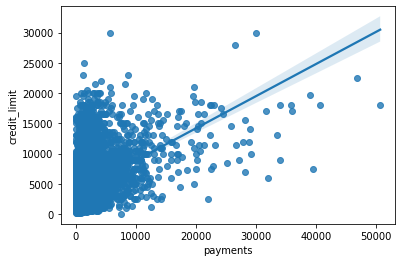

In [10]:
sns.regplot(data = df, y = 'credit_limit', x = 'payments')

Plotando a correlação entre as features. Ela varia entre -1 e 1:

*   Valor próximo a 0: fraca correlação (exatamente 0: nenhuma correlação);
*   Valor próximo a 1: forte correlação positiva;
*   Valor próximo a -1: forte correlação negativa.

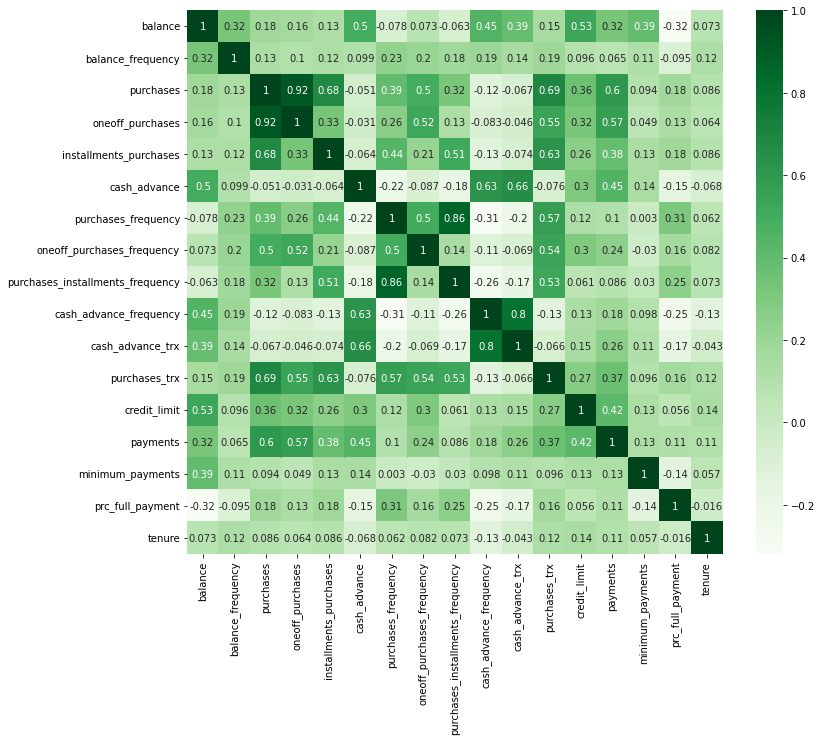

In [11]:
plt.figure(figsize=(12, 10))
corr = df.corr()
sns.heatmap(corr, annot = True, cmap=plt.cm.Greens)
plt.show()

In [12]:
# Dropando o id
df.drop(['cust_id'], axis = 1, inplace = True)

In [13]:
# Re-escalando os dados
ss = StandardScaler()
train_df = ss.fit_transform(df)
train_df.shape

(8950, 17)

In [14]:
train_df

array([[-0.73198937, -0.24943448, -0.42489974, ..., -0.31096755,
        -0.52555097,  0.36067954],
       [ 0.78696085,  0.13432467, -0.46955188, ...,  0.08931021,
         0.2342269 ,  0.36067954],
       [ 0.44713513,  0.51808382, -0.10766823, ..., -0.10166318,
        -0.52555097,  0.36067954],
       ...,
       [-0.7403981 , -0.18547673, -0.40196519, ..., -0.33546549,
         0.32919999, -4.12276757],
       [-0.74517423, -0.18547673, -0.46955188, ..., -0.34690648,
         0.32919999, -4.12276757],
       [-0.57257511, -0.88903307,  0.04214581, ..., -0.33294642,
        -0.52555097, -4.12276757]])

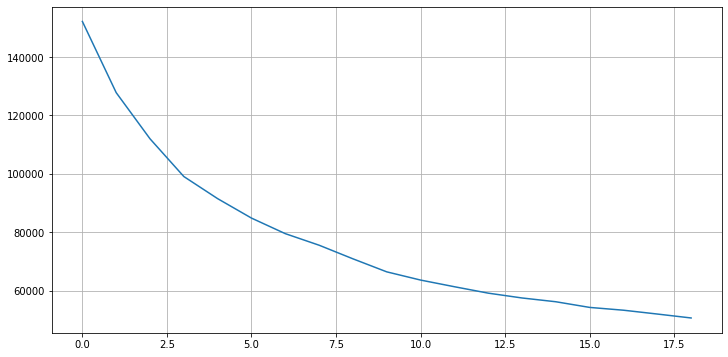

In [15]:
# Implementando o método para encontrar o número ótimo de clusters
first_score = []
for i in range(1,20):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(train_df)
    first_score.append(kmeans.inertia_) # inertia fornece a distância dentro do cluster de cada ponto de seu centróide
plt.figure(figsize=(12, 6))
plt.grid()
plt.plot (first_score)
plt.show()

In [16]:
# Podemos ver pelo gráfico que o número ótimo de clusters é 7 ou 8.
# Agora vamos aplicar o KMeans com o número ótimo de clusters (7).
kmeans = KMeans(7)
kmeans.fit(train_df)
labels = kmeans.labels_ #labels --> clusters

In [17]:
labels

array([5, 0, 4, ..., 1, 1, 1], dtype=int32)

In [18]:
kmeans.cluster_centers_.shape

(7, 17)

In [19]:
# Criando um dataframe de centros de clusters
cluster_centers = pd.DataFrame(data = kmeans.cluster_centers_, columns= [df.columns])
cluster_centers

,balance,balance_frequency,purchases,oneoff_purchases,installments_purchases,cash_advance,purchases_frequency,oneoff_purchases_frequency,purchases_installments_frequency,cash_advance_frequency,cash_advance_trx,purchases_trx,credit_limit,payments,minimum_payments,prc_full_payment,tenure
0,1.663792,0.392669,-0.201967,-0.148620,-0.204596,1.992010,-0.455555,-0.188318,-0.403211,1.909382,1.924500,-0.238255,1.007998,0.836019,0.551292,-0.390993,0.070132
1,-0.335506,-0.348076,-0.284525,-0.208973,-0.288475,0.065539,-0.198735,-0.272572,-0.230755,0.304112,-0.002216,-0.385586,-0.556898,-0.390701,-0.209383,0.012899,-3.193765
2,1.502824,0.406491,7.310815,6.389959,5.543973,0.015522,1.072591,1.833619,1.037771,-0.319186,-0.117442,4.843666,2.228858,5.034193,1.184700,0.806631,0.331183
3,-0.369445,0.331939,-0.039608,-0.231629,0.331717,-0.367885,0.980339,-0.346562,1.170583,-0.477326,-0.362676,0.172912,-0.275777,-0.222490,-0.029995,0.302713,0.252737
4,0.145405,0.430789,0.973329,0.924234,0.603424,-0.306381,1.101296,1.881282,0.548679,-0.405425,-0.315312,1.229431,0.721487,0.412311,-0.029577,0.471046,0.307178
5,0.006207,0.402229,-0.341623,-0.222082,-0.399650,-0.105357,-0.806912,-0.330724,-0.753163,0.082452,-0.043095,-0.462872,-0.300571,-0.247873,-0.016561,-0.451774,0.272059
6,-0.701904,-2.134551,-0.306916,-0.230647,-0.301846,-0.323078,-0.546754,-0.428845,-0.440392,-0.522249,-0.376815,-0.416229,-0.172322,-0.201754,-0.257536,0.297891,0.202040


In [20]:
# Como os dados estão normalizados, então vamos fazer a transformação inversa para conhecer melhor o que esse dado atual representa
cluster_centers = ss.inverse_transform(cluster_centers)
cluster_centers = pd.DataFrame(data = cluster_centers, columns= [df.columns])
cluster_centers
#Podemos separar os 4 clusters dados: Transactors, VIP.

,balance,balance_frequency,purchases,oneoff_purchases,installments_purchases,cash_advance,purchases_frequency,oneoff_purchases_frequency,purchases_installments_frequency,cash_advance_frequency,cash_advance_trx,purchases_trx,credit_limit,payments,minimum_payments,prc_full_payment,tenure
0,5027.516981,0.970290,571.698380,345.758223,226.053754,5156.210127,0.307514,0.146279,0.204191,0.517231,16.382123,8.787709,8161.960386,4153.336509,2148.970067,0.039356,11.611173
1,866.148306,0.794815,395.311749,245.585564,150.203132,1116.308792,0.410589,0.121144,0.272729,0.196000,3.233704,5.125596,2468.226470,602.104087,376.247870,0.157487,7.243243
2,4692.477130,0.973565,16622.873947,11198.460658,5424.413289,1011.421719,0.920833,0.749462,0.776874,0.071272,2.447368,135.105263,12603.947368,16306.639412,3625.099437,0.389640,11.960526
3,795.506183,0.955904,918.581021,207.980029,711.035467,207.398651,0.883808,0.099071,0.829657,0.039626,0.773833,19.007782,3491.060410,1089.057380,794.304573,0.242253,11.855545
4,1867.122633,0.979321,3082.736197,2126.476889,956.736635,336.376848,0.932354,0.763681,0.582496,0.054014,1.097056,45.268894,7119.512548,2926.743202,795.279349,0.291487,11.928401
5,1577.394300,0.972555,273.322996,223.827204,49.669435,757.933033,0.166498,0.103796,0.065111,0.151644,2.954737,3.204561,3400.847953,1015.575030,825.611723,0.021578,11.881404
6,103.520510,0.371615,347.473614,209.611297,138.112359,301.361116,0.270912,0.074525,0.189414,0.030637,0.677338,4.363943,3867.472152,1149.086960,264.029590,0.240843,11.787700


In [21]:
labels.shape # valores associados para cada ponto

(8950,)

In [22]:
labels.max()

6

In [23]:
labels.min()

0

In [24]:
# Podemos ter o label associado com cada ponto
ykmeans = kmeans.fit_predict(train_df)
ykmeans

array([1, 6, 0, ..., 4, 1, 2], dtype=int32)

In [25]:
# Concatenando o cluster de labels com o dataset original, isso irá ajudar a plotar os histogramas de cada cluster
train_df_cluster = pd.concat([df, pd.DataFrame({'cluster': labels})], axis = 1)
train_df_cluster.head()

,balance,balance_frequency,purchases,oneoff_purchases,installments_purchases,cash_advance,purchases_frequency,oneoff_purchases_frequency,purchases_installments_frequency,cash_advance_frequency,cash_advance_trx,purchases_trx,credit_limit,payments,minimum_payments,prc_full_payment,tenure,cluster
0,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12,5
1,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12,0
2,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12,4
3,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,864.206542,0.000000,12,5
4,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12,5


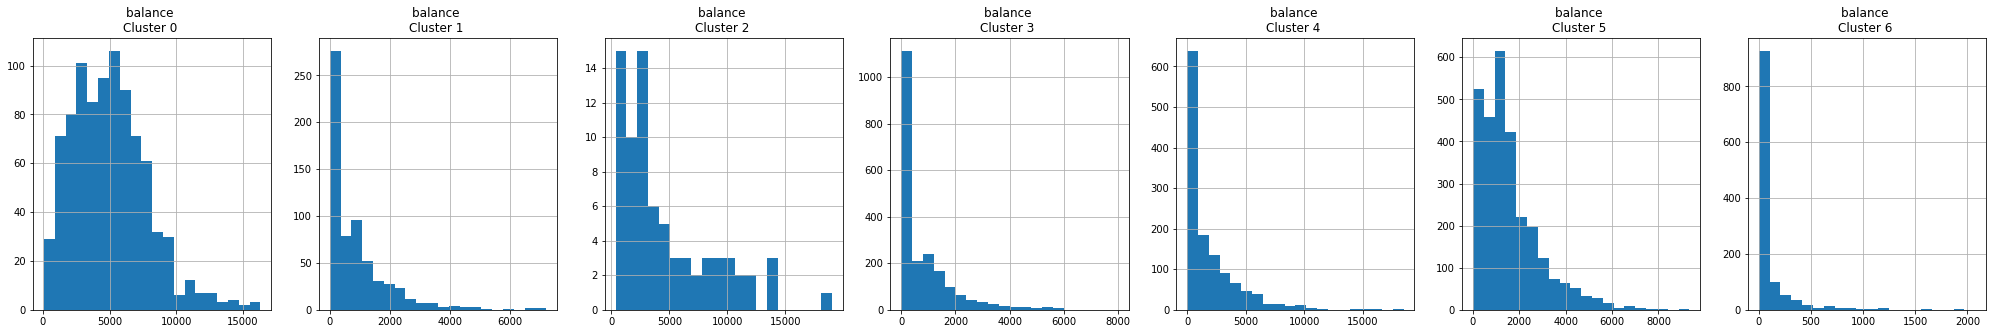

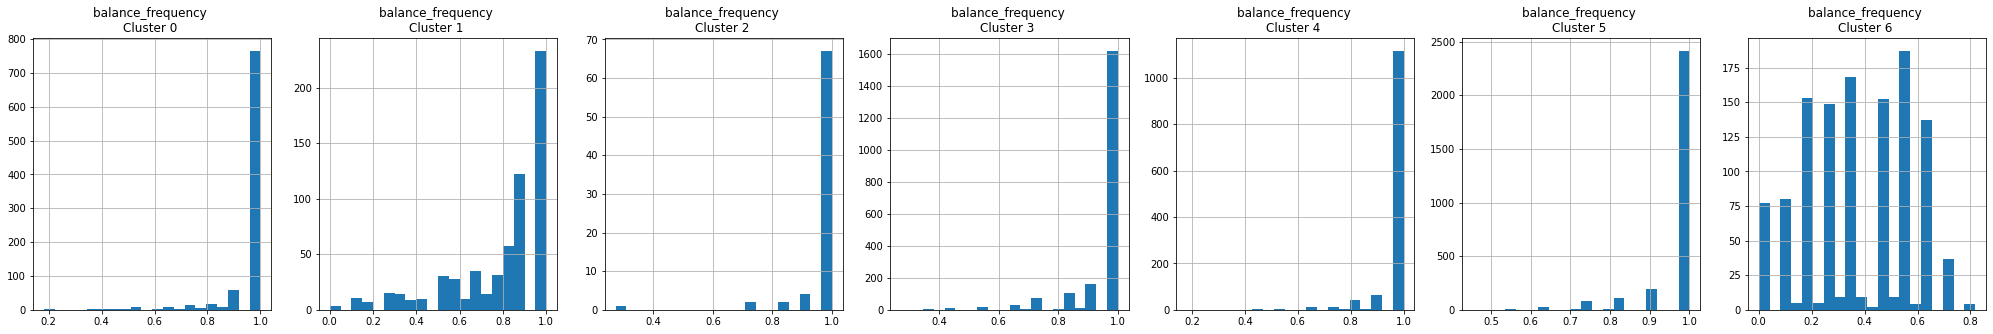

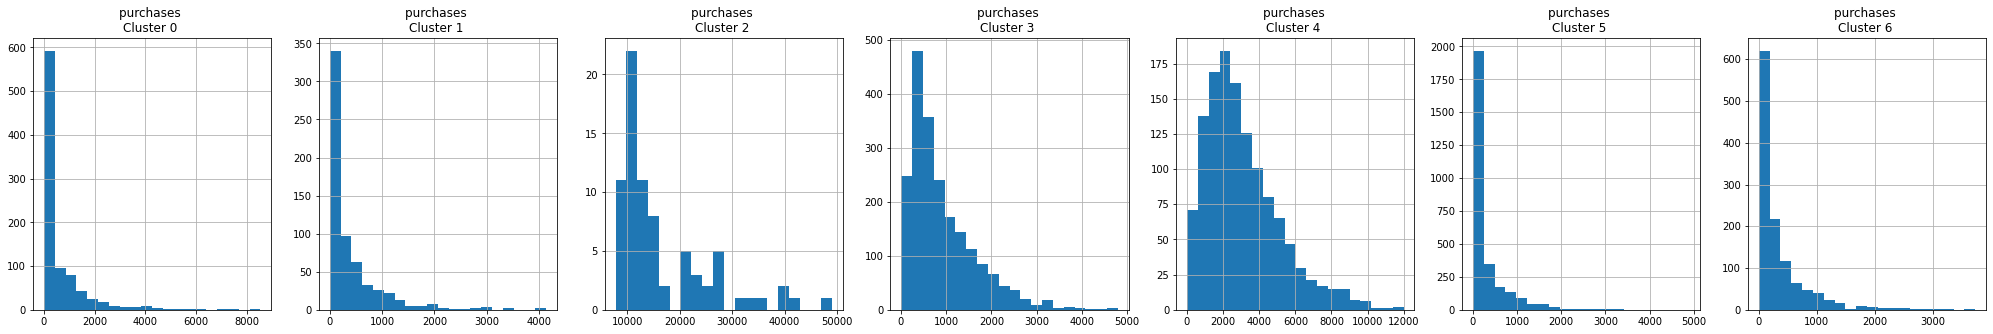

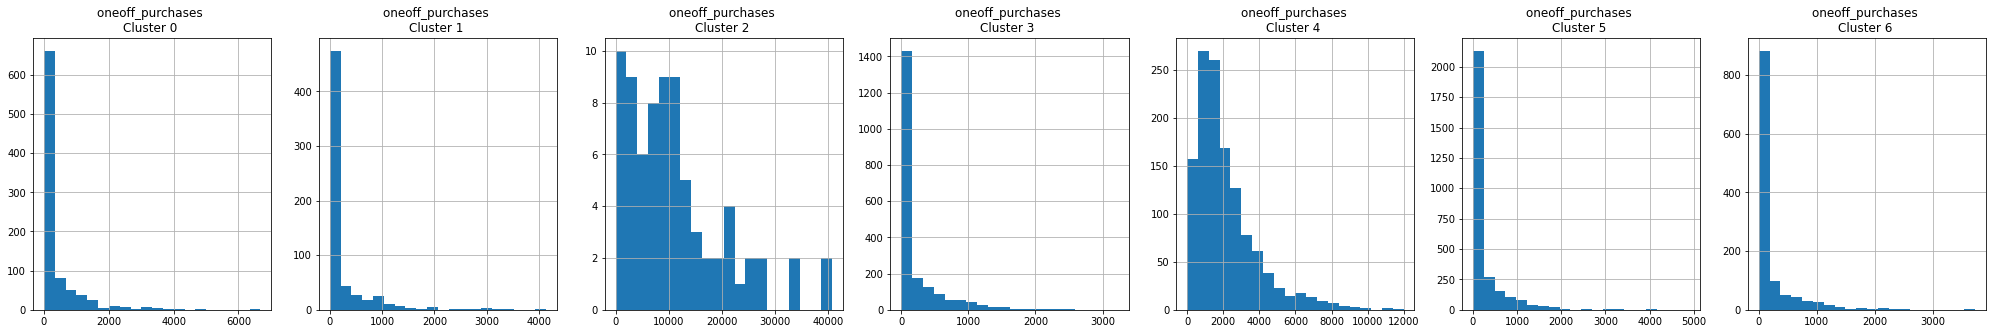

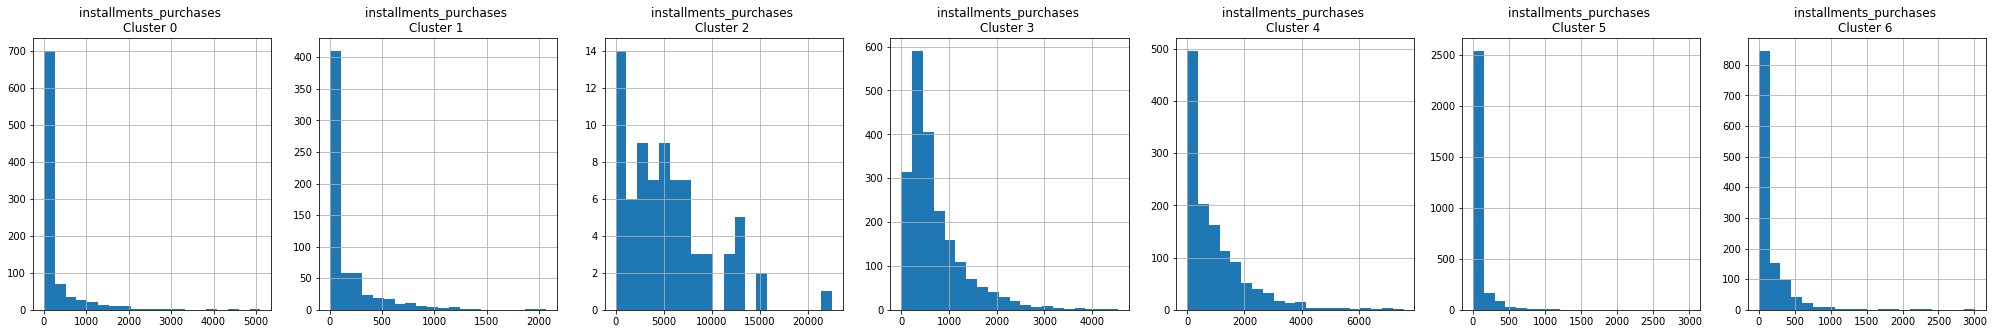

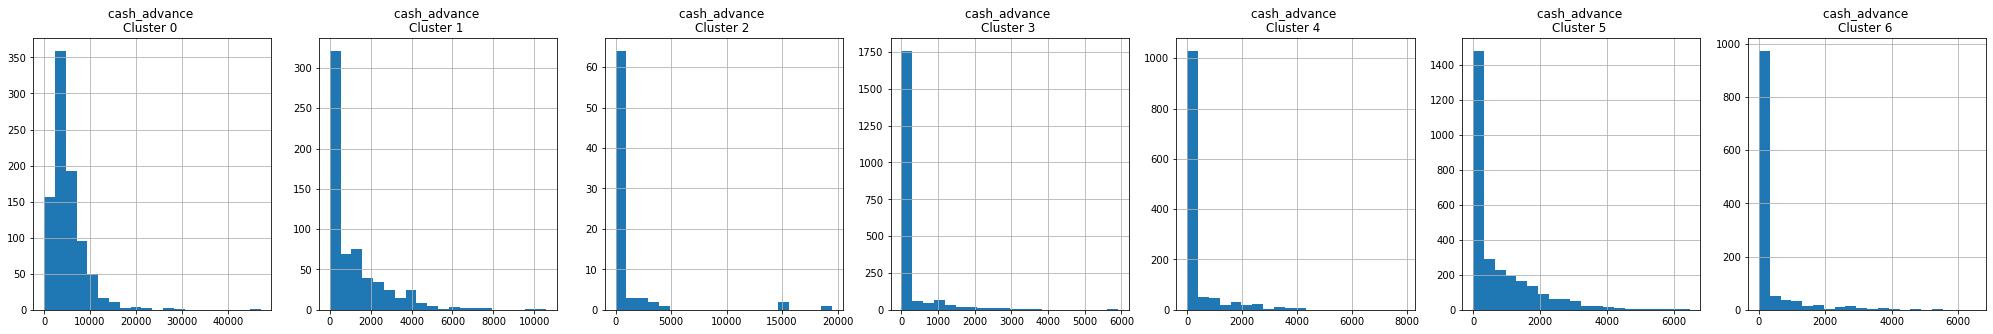

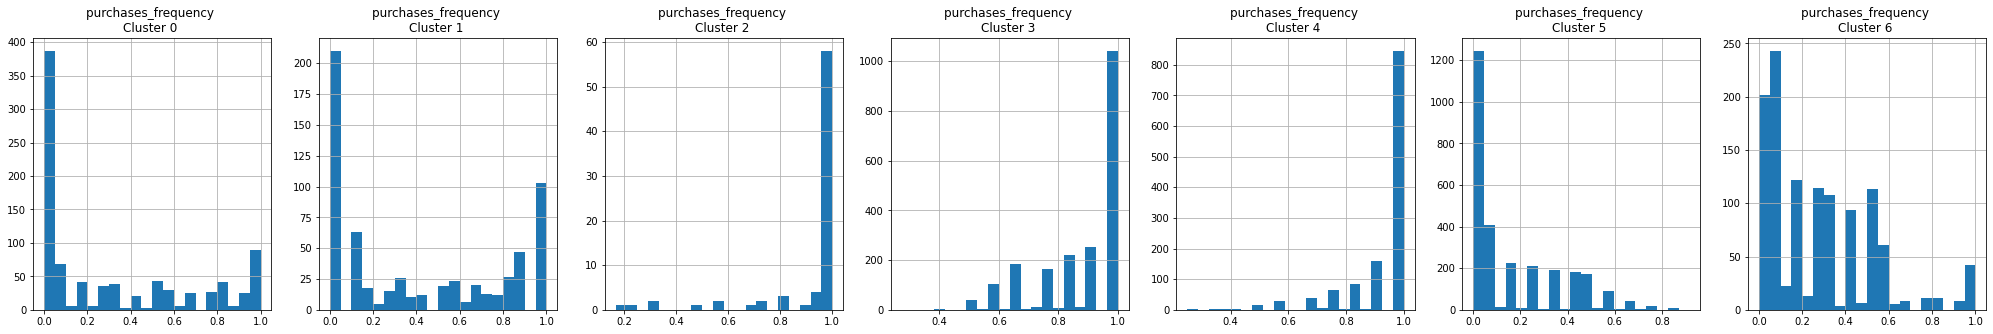

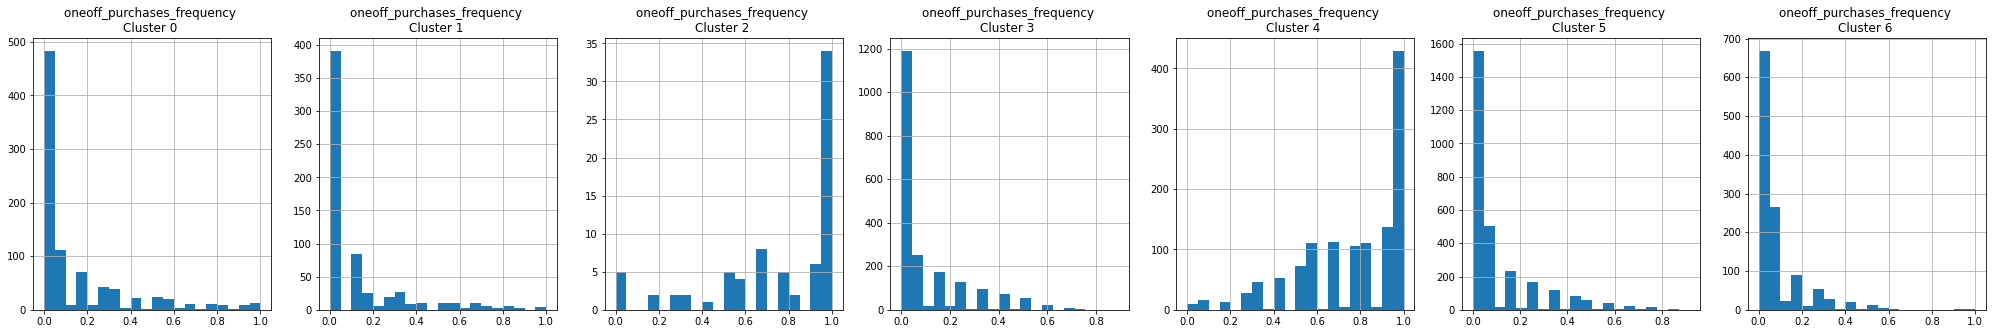

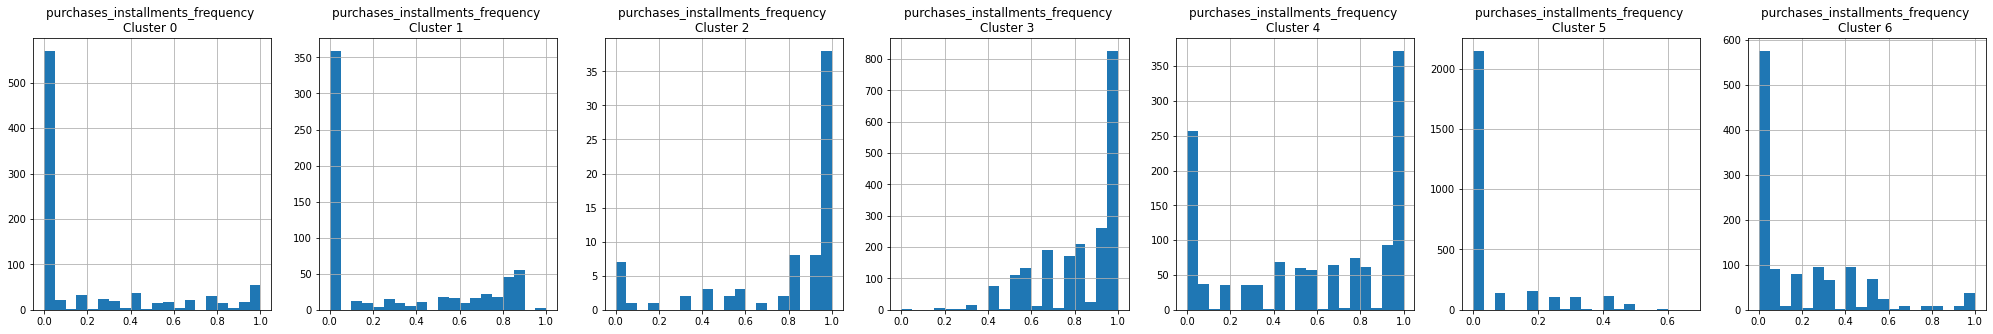

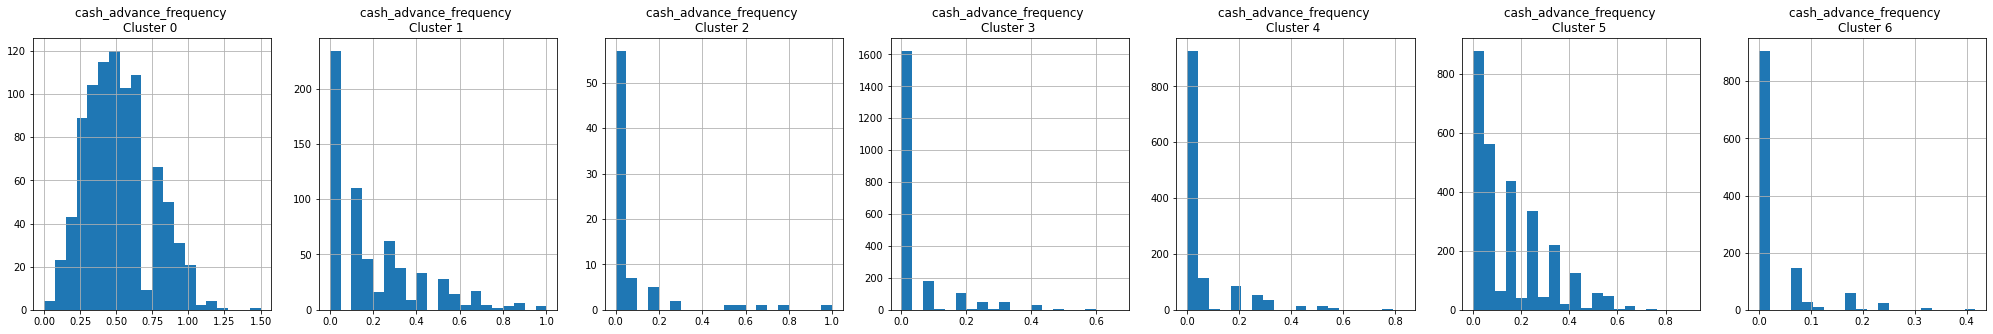

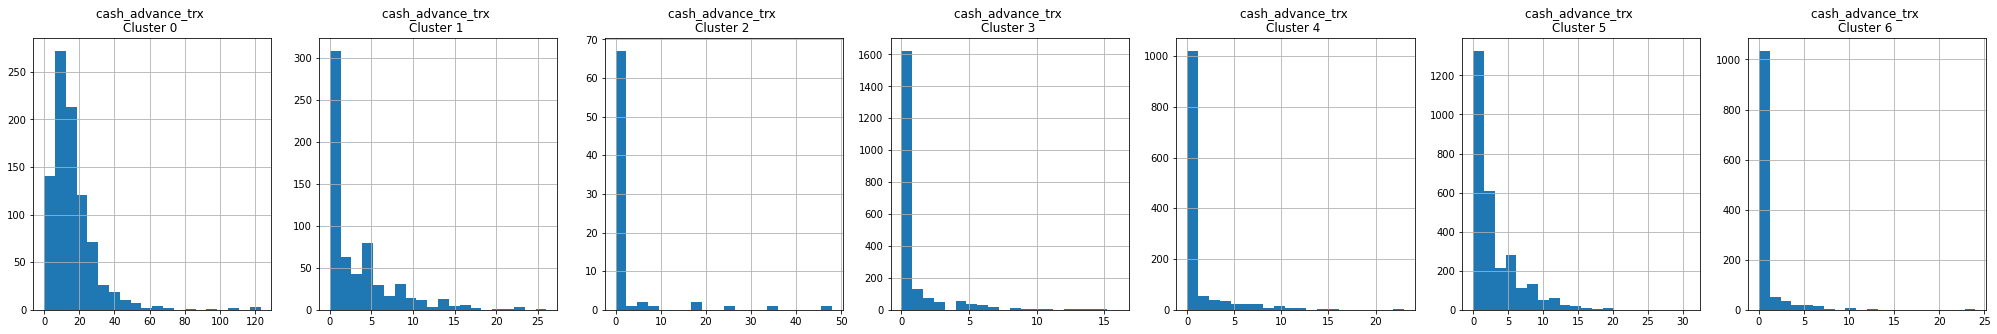

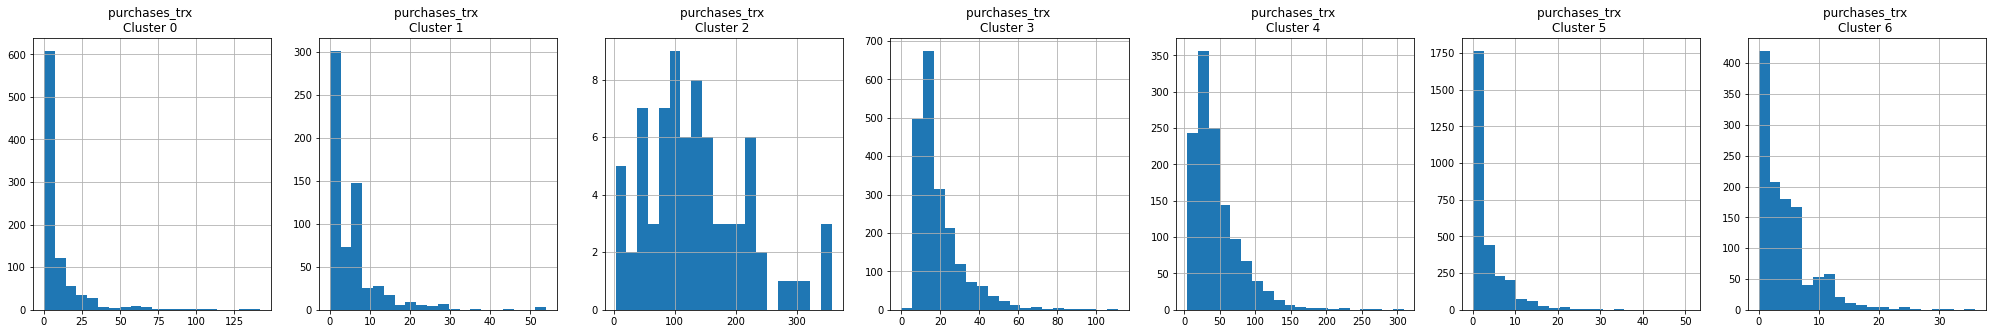

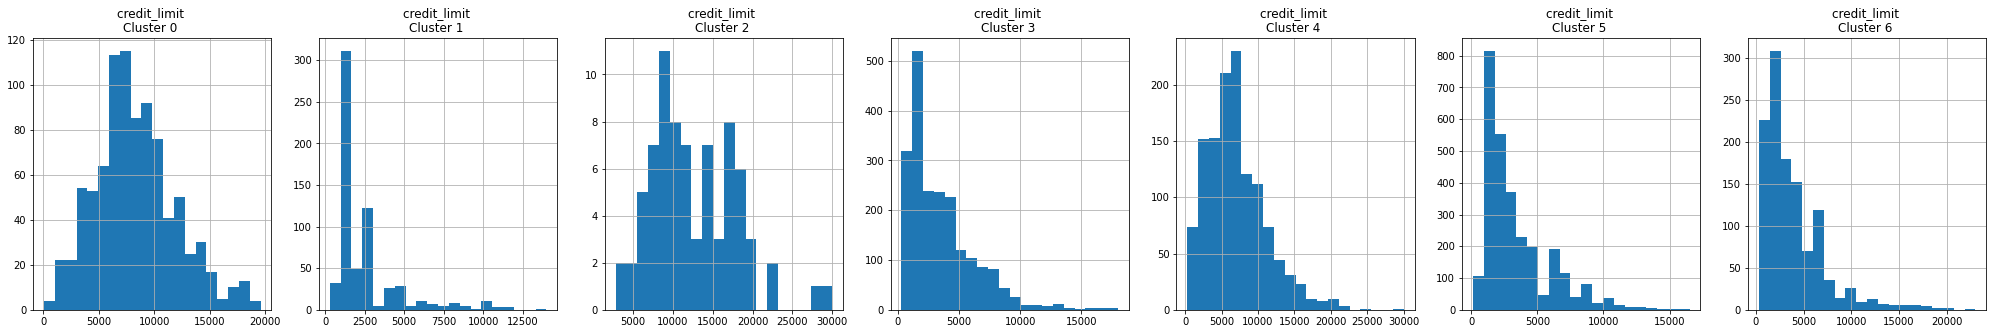

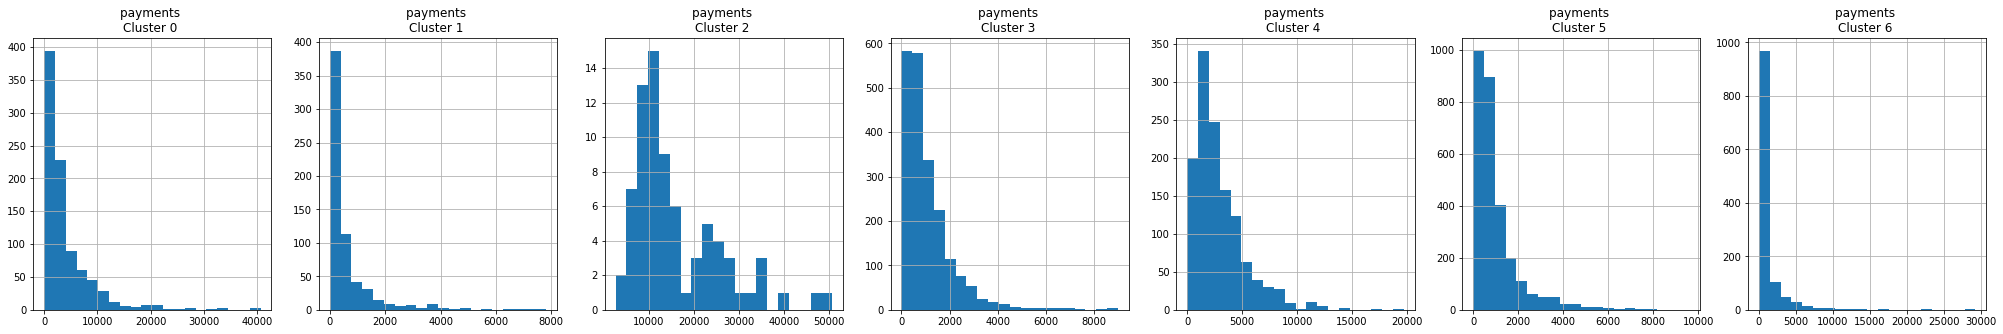

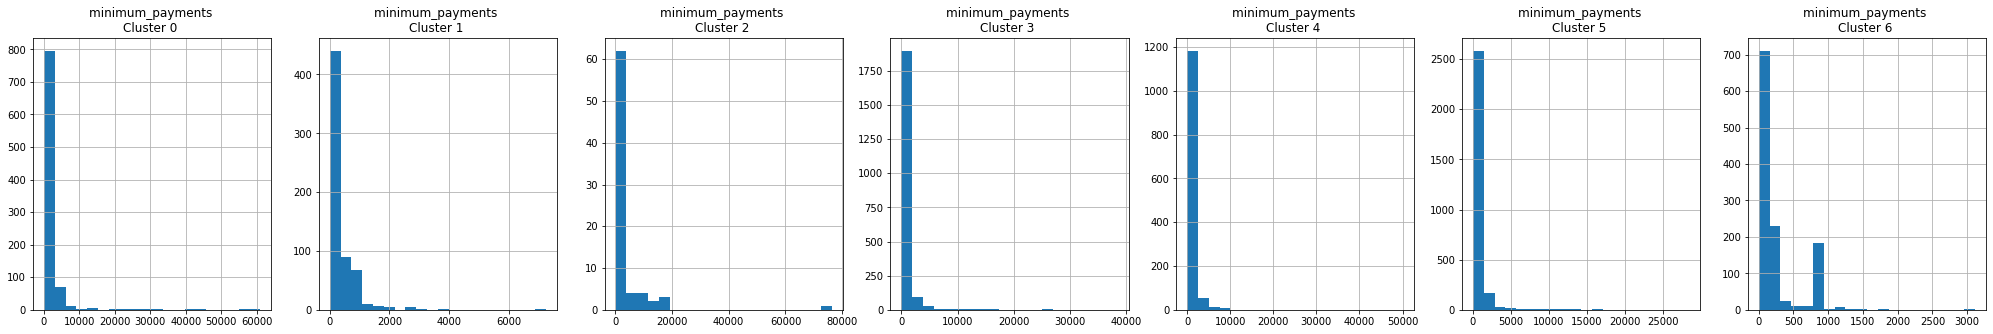

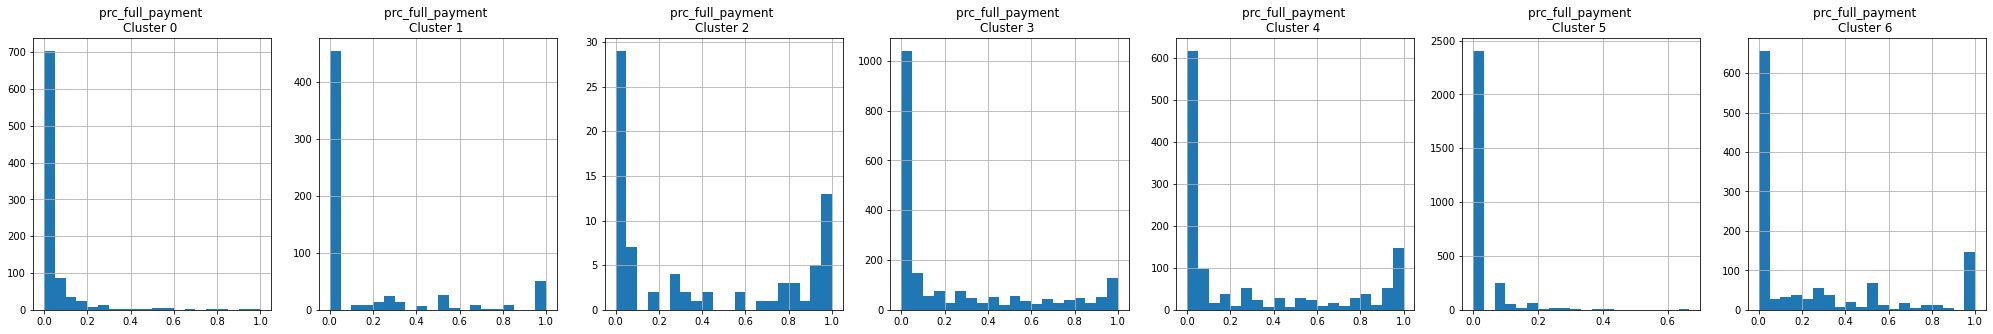

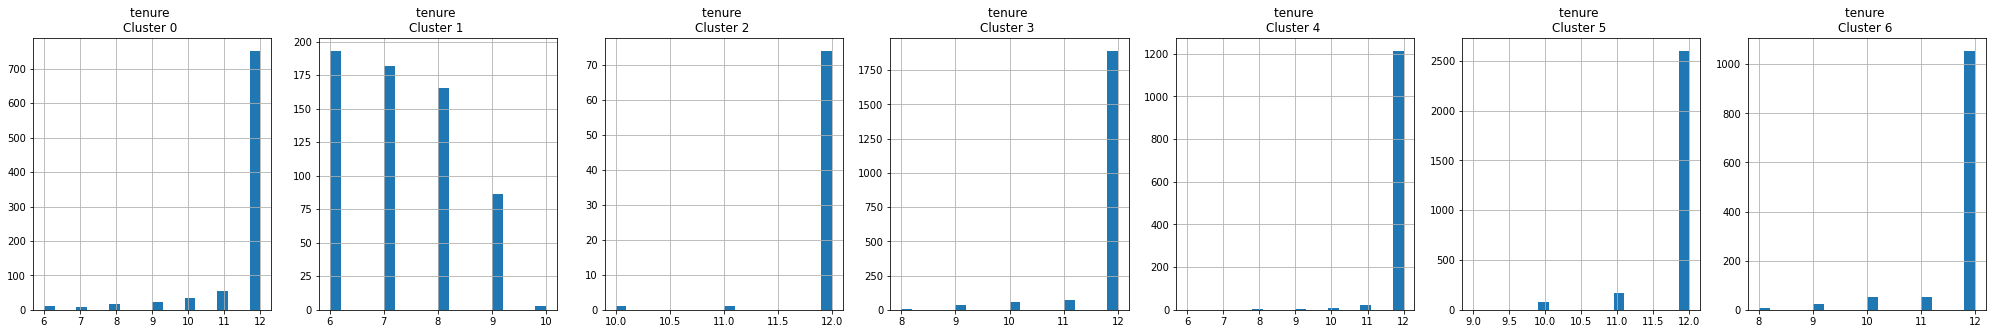

In [26]:
# Plotando os histogramas de cada cluster
for i in df.columns:
    plt.figure(figsize=(35,5))
    for j in range(7):
        plt.subplot(1,7,j+1)
        cluster = train_df_cluster[train_df_cluster['cluster']==j]
        cluster[i].hist(bins=20)
        plt.title('{} \nCluster {} '.format(i,j))
    plt.show()

In [27]:
# Vamos usar o PCA para converter nossos dados em 2D. O PCA reduz a dimensionalidade dos dados, preservando a informação.
pca = PCA(n_components=2)
pca_components = pca.fit_transform(train_df)
pca_components

array([[-1.68222055, -1.07645387],
       [-1.13831282,  2.50649309],
       [ 0.96969282, -0.38353588],
       ...,
       [-0.926199  , -1.81079368],
       [-2.33654882, -0.65796681],
       [-0.55642229, -0.40045746]])

In [28]:
# Criando o array 2D (com 2 componentes)
pca_df = pd.DataFrame(data = pca_components, columns = ['pca1', 'pca2'])
pca_df.head()

,pca1,pca2
0,-1.682221,-1.076454
1,-1.138313,2.506493
2,0.969693,-0.383536
3,-0.873623,0.043157
4,-1.599435,-0.688583


In [29]:
# Concatenando os labels
pca_df = pd.concat([pca_df, pd.DataFrame({'cluster': labels})], axis = 1)
pca_df.head()

,pca1,pca2,cluster
0,-1.682221,-1.076454,5
1,-1.138313,2.506493,0
2,0.969693,-0.383536,4
3,-0.873623,0.043157,5
4,-1.599435,-0.688583,5


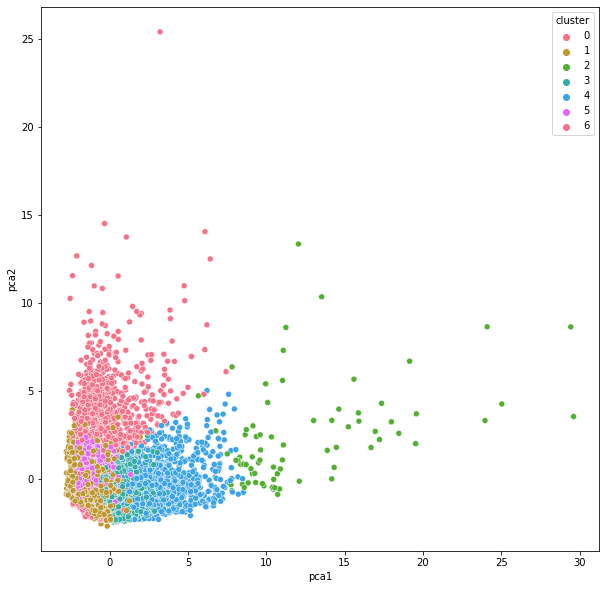

In [30]:
# Plotando os clusters
plt.figure(figsize=(10,10))
ax = sns.scatterplot(x='pca1', y='pca2', hue = 'cluster', data=pca_df, palette="husl")
plt.show()